# Classification avec un réseau de neurones (version pytorch)

Ce notebook illustre sur un exemple simple comment utiliser pytorch pour implémenter un réseau de neurone qui réalise une classification binaire 

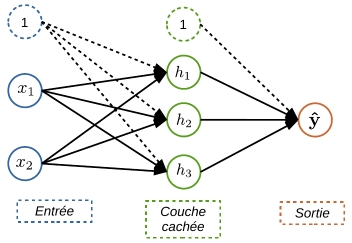


On ajoute ici les paquets pytorch utiles pour notre exemple

### Imports python

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
%matplotlib inline

#Import pytorch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## 1. Chargement et visualisation des données

On commence par charger nos données, qui sont de dimension 2, et de 2 classes différentes. On choisit d'abord le dataset ```moon```. On pourra sélectionner un autre dataset ici par la suite.

In [ ]:
#Nombre d'échantillons dans la base de données
N_samples = 4000

#Choisir le dataset ici !
#Dataset moon
features, labels = datasets.make_moons(n_samples=N_samples, noise=.15,random_state=0)
#Dataset blobs
#features, labels = datasets.make_blobs(n_samples=N_samples, cluster_std=0.3, centers=[(-0.1, -0.2), (1.2, 1.4)], n_features=2, random_state=0)
#Dataset circles
#features, labels= datasets.make_circles(n_samples=N_samples, shuffle=True, noise=0.1, factor=0.3,random_state=0)

# Afficher les 10 premiers exemples pour se faire une idée des données
print(features[:10,:])

# Affichage des données
pos = plt.scatter(features[0:N_samples:, 0][labels==1], features[0:N_samples, 1][labels==1], c='g', marker = '+', s=10, label='Class 1')
neg = plt.scatter(features[0:N_samples:, 0][labels==0], features[0:N_samples, 1][labels==0], c='b', marker = '+', s=10, label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper right',fontsize=12)
plt.show()

## 2. Séparer les données en un ensemble d'entrainement et un ensemble de test

On sépare nos données en 1 ensemble d'entrainement et 1 ensemble de test

In [ ]:
# Caractéristiques (features) : [x1, x2]
# Pourcentage d'échantillons utilisés pour l'entrainement
ratio_train_test = 0.75
N_train = int(ratio_train_test*N_samples)


# split train and test :
# Train dataset
features_train = features[0:N_train,:]
labels_train = labels[0:N_train].reshape(-1,1)
# Test dataset
features_test = features[N_train:N_samples,:]
labels_test = labels[N_train:].reshape(-1,1)

### Conversion des données en tenseurs pytorch

On convertit ici les données dans le format de tenseurs pytorch pour pouvoir les utiliser avec les fonctions pytorch par la suite, et on construit le dataset pytorch :

In [ ]:
# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
X_train_t = torch.from_numpy(features_train).type(torch.FloatTensor)
Y_train_t = torch.from_numpy(labels_train).type(torch.FloatTensor)
train_data = TensorDataset(X_train_t, Y_train_t)
print('dataset entrainement : ', train_data)

X_test_t = torch.from_numpy(features_test).type(torch.FloatTensor)
Y_test_t = torch.from_numpy(labels_test).type(torch.FloatTensor)
test_data = TensorDataset(X_test_t, Y_test_t)
print('dataset test : ', test_data)

## 4. Construction du modèle 



### Modèle et prédictions

On définit notre réseau de neurones dans une classe spécifique ici. La fonction ```forward``` réalise notre propagation en avant, pour obtenir les probabilités (entre $0$ et $1$). La fonction ```predict``` calcule les labels prédits : pour cela elle calcule d'abord les probabilités prédites en utilisant la fonction ```forward``` puis arrondit à l'entier le plus proche pour obtenir des labels $=0$ ou $=1$.

Note : **la rétropropagation n'a pas besoin d'être implémentée, elle sera calculée automatiquement par pytorch** pour nous à partir de la fonction ```forward``` !

In [ ]:
# Hyperparamètres
# Choisir ici le nombre de neurones de la couche cachée :
H = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, H),
            nn.Sigmoid(),
            nn.Linear(H, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x
    
    def predict(self, x):        
        outputs = self.forward(x)  
        return np.round(outputs.detach().numpy()[:,0])


# Pour rendre les tirages aléatoires reproductibles (facultatif)   
torch.manual_seed(0)

# Création du réseau : 
model = Net()

# Affichage de l'architecture :
print(model)

## 5. Entrainement

### Préparation à l'entrainement


In [ ]:
# Hyperparamètres
N_epochs = 1000
batch_size = 300
learning_rate = 1

#### Choix de la fonction de coût
https://pytorch.org/docs/master/nn.html#loss-functions

In [ ]:
loss_function = nn.BCELoss(reduction ='mean')
#loss_function = nn.MSELoss()

#### Choix de l'optimiseur
https://pytorch.org/docs/master/optim.html#algorithms

In [ ]:
# Choix de l'optimiseur
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # SGD
#optimizer = optim.Adam(net.parameters(), lr=0.005) # ADAM

In [ ]:
# Outil de chargement des données
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

### Entrainement du réseau
L'exemple ci-dessous illustre une descente de gradient simple, mais on pourra également réaliser une descente de gradient stochastique en sélectionnant des lots de données.

In [ ]:
# Nombre d'itérations
losses = []   
for epoch in range(N_epochs):  # Boucle sur les époques    
    for features, labels in train_dataloader:
        #Propagation en avant
        labels_pred = model(features) # Equivalent à model.forward(features)

        #Calcul du coût
        loss = loss_function(labels_pred,labels)

        #on sauvegarde la loss pour affichage futur
        losses.append(loss.item())

        #Effacer les gradients précédents
        optimizer.zero_grad()

        #Calcul des gradients (rétro-propagation)
        loss.backward()

        #Mise à jour des poids : un pas de l'optimiseur
        optimizer.step()
        
    if epoch % 100 == 99:
            print('Epoque',epoch, 'loss', loss.item())
    
print('Entrainement terminé')

In [ ]:
# Afficher l'évolution de la fonction de coût
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Fonction de cout')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Cout',fontsize=18)
plt.legend(loc='upper right',fontsize=16)

## 6. Evaluation des performances

In [ ]:
# Evaluation des performances sur l'ensemble d'entrainement
# Accuracy
def accuracy(predicted_labels, actual_labels):
    diff = predicted_labels - actual_labels
    return 1.0 - np.sum(np.abs(diff))/len(diff)


# Evaluation des performances 
# train dataset
predicted_labels_train = model.predict(torch.from_numpy(features_train).type(torch.FloatTensor)).reshape(-1,1)
accuracy_prediction_train = accuracy(predicted_labels_train, labels_train)
print('Taux de bonnes prédictions (train dataset): %.3f' % accuracy_prediction_train)


# test dataset
predicted_labels_test = model.predict(torch.from_numpy(features_test).type(torch.FloatTensor)).reshape(-1,1)
accuracy_prediction_test = accuracy(predicted_labels_test, labels_test)
print('Taux de bonnes prédictions (test dataset): %.3f' % accuracy_prediction_test)

In [ ]:
def plot_decision_boundary(pred_func,X,y,markers):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, levels=[0., 0.5, 1.], colors = ['lightsteelblue','mintcream'])
    pos = plt.scatter(X[:, 0][y[:,0]==1], X[:, 1][y[:,0]==1], c='g', marker = '+', s=10, label='Class 1')
    neg = plt.scatter(X[:, 0][y[:,0]==0], X[:, 1][y[:,0]==0], c='b', marker = '+', s=10, label='Class 2')
    plt.xlabel('x1')
    plt.ylabel('x2')


plot_decision_boundary(lambda x : model.predict(torch.from_numpy(x).type(torch.FloatTensor)), features_train, labels_train,'+')